# This module is for the simple method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model  
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, confusion_matrix
from utils import *
%matplotlib inline

/home/sven/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load LSTM model
lookback = 10
hidden_neurons = 300
model = load_model('../LSTM_{}_{}.model'.format(lookback, hidden_neurons))

# load second normal validation dataset and abnormal validation dataset
val2 = pd.read_csv('../val2_treated.csv', index_col=0)
vala = pd.read_csv('../vala_treated.csv', index_col=0)

# Grid search
In this section, we search for the optimal size of the window.

In [3]:
# grid search
memory_widths = [1, 3, 5, 8, 10]

err_avg_n = [[] for i in range(len(memory_widths))]
val2_brokens = getBrokens(val2.index)
for i in range(len(val2_brokens)-1):
    val2X, val2Y = createSequnces(val2.iloc[val2_brokens[i]:val2_brokens[i+1], :], lookback)
    predY = model.predict(np.array(val2X))
    errors = pointError(val2Y, predY)
    for j, memory_width in enumerate(memory_widths):
        err_avg_n[j] += windowAverage(errors, memory_width)

err_avg_a = [[] for i in range(len(memory_widths))]
vala_brokens = getBrokens(vala.index)
for i in range(len(vala_brokens)-1):
    valaX, valaY = createSequnces(vala.iloc[vala_brokens[i]:vala_brokens[i+1], :], lookback)
    if len(valaY) == 0:
        continue
    predY = model.predict(np.array(valaX))
    errors = pointError(valaY, predY)
    for j, memory_width in enumerate(memory_widths):
        err_avg_a[j] += windowAverage(errors, memory_width)

In [4]:
# calculate precision, recall, f1-score and threshold for each memory width
bm = []
for i, memory_width in enumerate(memory_widths):
    value_label = np.array([[err, 0] for err in err_avg_n[i]] + [[err, 1] for err in err_avg_a[i]])
    p, r, f1, ts = getOptimalFscore(value_label[:,1], value_label[:, 0], beta=1)
    bm.append( [memory_width, p, r, f1, ts])

bm = pd.DataFrame(bm, columns=['memory_width', 'precision', 'recall', 'f-score', 'threshold'])

In [5]:
# print the benchmark results
bm

,memory_width,precision,recall,f-score,threshold
0,1,0.857143,0.786885,0.820513,0.012206
1,3,0.920000,0.807018,0.859813,0.013270
2,5,0.959184,0.886792,0.921569,0.011493
3,8,1.000000,0.978723,0.989247,0.011186
4,10,1.000000,1.000000,1.000000,0.012037


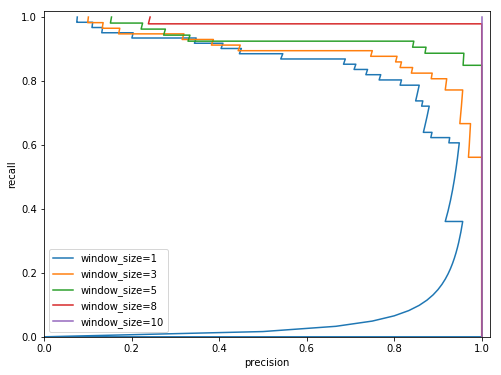

In [6]:
# plot precision-recall curve
plt.figure(figsize=(8, 6))
for i, memory_width in enumerate(memory_widths):
    value_label = np.array([[err, 0] for err in err_avg_n[i]] + [[err, 1] for err in err_avg_a[i]])
    p_trace, r_trace, _ = precision_recall_curve(value_label[:, 1], value_label[:, 0])
    plt.plot(p_trace, r_trace, label="window_size={}".format(memory_width))
plt.xlabel('precision')
plt.ylabel('recall')
plt.xlim((0,1.02))
plt.ylim((0,1.02))
plt.legend(loc='best')
plt.show()

# Testing
In this section, we apply the testing dataset to our model.

In [7]:
testn = pd.read_csv('../testn_treated.csv', index_col=0)
testa = pd.read_csv('../testa_treated.csv', index_col=0)

bm_test = []
for i, memory_width in enumerate(memory_widths):

    err_avg_test_n = []
    testn_broken = getBrokens(testn.index)
    for i in range(len(testn_broken)-1):
        testnX, testnY = createSequnces(testn.iloc[testn_broken[i]:testn_broken[i+1], :], lookback)
        if len(testnY) == 0:
            continue
        predY_n = model.predict(np.array(testnX))
        errors_n = pointError(testnY, predY_n)
        err_avg_test_n += windowAverage(errors_n, memory_width)

    err_avg_test_a = []
    testa_broken = getBrokens(testa.index)
    for i in range(len(testa_broken)-1):
        testaX, testaY = createSequnces(testa.iloc[testa_broken[i]:testa_broken[i+1], :], lookback)
        if len(testaY) == 0:
            continue
        predY_a = model.predict(np.array(testaX))
        errors_a = pointError(testaY, predY_a)
        err_avg_test_a += windowAverage(errors_a, memory_width)

    ts = bm.iloc[i, 4]
    value_label_test = np.array([[err, 0, int(err >= ts)] for err in err_avg_test_n] + 
                                [[err, 1, int(err >= ts)] for err in err_avg_test_a])
    precision, recall, f1, _ = precision_recall_fscore_support(value_label_test[:, 1], 
                                                           value_label_test[:, 2], 
                                                           average='binary')
#     print(precision, recall, f1)
    bm_test.append([memory_width, precision, recall, f1])
bm_test = pd.DataFrame(bm_test, columns=['memory_width', 'precision', 'recall', 'f-score'])

In [8]:
bm_test

,memory_width,precision,recall,f-score
0,1,0.522222,0.770492,0.622517
1,3,0.505376,0.824561,0.626667
2,5,0.536585,0.830189,0.651852
3,8,0.537500,0.914894,0.677165
4,10,0.709677,1.000000,0.830189
